In [13]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'svg'

learn_path = Path('../results/learnability_faithfulness/gpt_4_1/rule_2_17.json')
learn_data = json.loads(learn_path.read_text())
learn_counts = {quad: {"true": 0, "false": 0} for quad in ["TT","TF","FT","FF"]}
for rec in learn_data['records']:
    quad = rec['quadrant']
    pred = rec['prediction']
    pred_val = pred.strip().lower() == 'true' if isinstance(pred, str) else bool(pred)
    learn_counts[quad]['true' if pred_val else 'false'] += 1

learn_df = pd.DataFrame({
    (quad[0], quad[1]): {
        'total': learn_counts[quad]['true'] + learn_counts[quad]['false'],
        'true_count': learn_counts[quad]['true'],
        'true_pct': (learn_counts[quad]['true'] / (learn_counts[quad]['true'] + learn_counts[quad]['false']) * 100)
                    if (learn_counts[quad]['true'] + learn_counts[quad]['false']) else np.nan
    }
    for quad in ['TT','TF','FT','FF']
}).T
learn_df.index = pd.MultiIndex.from_tuples([(f"Rule 2 = {quad[0]}", f"Rule 17 = {quad[1]}") for quad in ['TT','TF','FT','FF']])

for rec in learn_data['records']:
    print(rec['quadrant'])
    print(rec['prediction'])
    break

TF
False


In [3]:




free_path = Path('../results/articulation_free_faithfulness/gpt_4_1_2025_04_14/rule_2_17.json')
free_data = json.loads(free_path.read_text())
overall_stats = free_data['summary']['datasets']['overall']['quadrant_stats']
free_df = pd.DataFrame({
    (quad[0], quad[1]): {
        'total': stats['total'],
        'true_count': stats['true'],
        'true_pct': stats['true_rate'] * 100 if stats['true_rate'] is not None else np.nan
    }
    for quad, stats in overall_stats.items()
}).T
free_df.index = pd.MultiIndex.from_tuples([(f"Rule 2 = {quad[0]}", f"Rule 17 = {quad[1]}") for quad in overall_stats])

learn_df, free_df

(                        total  true_count    true_pct
 Rule 2 = T Rule 17 = T  100.0       100.0  100.000000
            Rule 17 = F   80.0         0.0    0.000000
 Rule 2 = F Rule 17 = T  105.0       104.0   99.047619
            Rule 17 = F  115.0         2.0    1.739130,
                           total  true_count   true_pct
 Rule 2 = T Rule 17 = T  18685.0     18222.0  97.522077
            Rule 17 = F  18500.0      4189.0  22.643243
 Rule 2 = F Rule 17 = T  18685.0     18027.0  96.478459
            Rule 17 = F  18500.0      4394.0  23.751351)

/var/folders/jd/3wx8xlzs6fg2cht_mgvlkhy80000gn/T/ipykernel_14961/1126488694.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(base_cmap_name, 512)


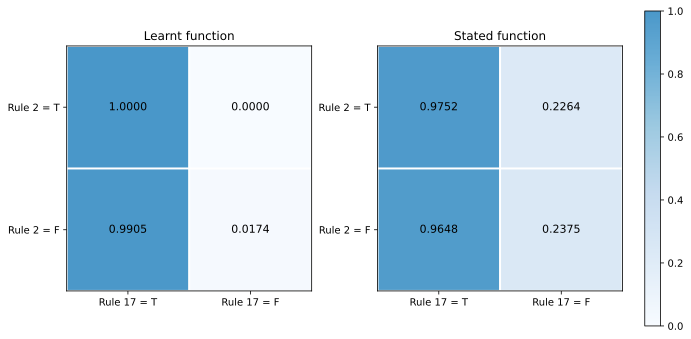

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm

# === Data ===
cm_learnt = np.array([
    [1.0000, 0.0000],  # TT, TF
    [0.9905, 0.0174],  # FT, FF
])

cm_stated = np.array([
    [0.9752, 0.2264],
    [0.9648, 0.2375],
])

# Helper: use only the lighter half of "Blues" (avoids the darkest tones)
def truncated_cmap(base_cmap_name="Blues", minval=0.0, maxval=0.6, n=256):
    base = cm.get_cmap(base_cmap_name, 512)
    new_colors = base(np.linspace(minval, maxval, n))
    return colors.ListedColormap(new_colors)

cmap_light = truncated_cmap("Blues", 0.0, 0.6)  # cap at ~60% darkness

fig, axes = plt.subplots(1, 2, figsize=(9.5, 4.6), constrained_layout=True)

def render(ax, mat, title):
    im = ax.imshow(mat, cmap=cmap_light, vmin=0.0, vmax=1.0, aspect='equal')
    ax.set_xticks([0, 1], labels=["Rule 17 = T", "Rule 17 = F"])
    ax.set_yticks([0, 1], labels=["Rule 2 = T", "Rule 2 = F"])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat[i, j]:.4f}", ha="center", va="center", fontsize=11, color="black")
    ax.set_xticks(np.arange(-0.5, mat.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, mat.shape[0], 1), minor=True)
    ax.grid(which="minor", color="white", linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)
    return im

# Learnt function (left), Stated function (right)
im_left  = render(axes[0], cm_learnt, "Learnt function")
im_right = render(axes[1], cm_stated, "Stated function")

# Shared colorbar
cbar = fig.colorbar(im_left, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label("", rotation=270, labelpad=12)

plt.show()
